In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
np.random.seed(42)

In [3]:
#read the input drug-metabolite data
data = pd.read_csv('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\data\\Carboplatin_metabolic_NCI.csv')
data.head(2)

,Cell Line,Acetone ; Propanal ; acetone,Acetaldehyde oxime ; HMDB01122,acetate,Urea,Isopropyl alcohol ; Propyl alcohol,Bicarbonate ; Hydrogen carbonate,Dimethylsulfide,3-Butyn-1-al,1-pyrrolinium,...,O-b-D-glucopyranosyl-(1->3)-O-2-(acetylamino)-2-deoxy-b-D-glucopyranosyl-(1->3)-O-[6-deoxy-a-L-galactopyranosyl-(1->4)]-O-b-D-galactopyranosyl-(1->4)-O-[6-deoxy-a-L-galactopyranosyl-(1->3)]-D-Glucose,LS tetrasaccharide d ; Sialyllacto-N-neotetraose c ; Sialyllacto-N-tetraose a ; Sialyllacto-N-tetraose b ; Sialyllacto-N-tetraose c,PIP2(16:0/18:0) ; PIP2(18:0/16:0),"TG(22:5(7Z,10Z,13Z,16Z,19Z)/20:5(5Z,8Z,11Z,14Z,17Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))[iso6] ; TG(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/20:4(5Z,8Z,11Z,14Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))[iso3]","(2E)-Hexadecenoyl-CoA ; 2,7,10-hexadecatrienoylcoa ; 3,7,10-hexadecatrienoylcoa ; 3Z,7Z,10Z-hexadecatrienoyl-CoA ; 4,7,10-hexadecatrienoylcoa ; 4Z,7Z,10Z-hexadecatrienoyl-CoA ; 7,10,13-hexadecatrienoylcoa ; trans,cis,cis-2,7,10-hexadecatrienoyl-CoA",Lacto-N-difucohexaose ; Lacto-N-difucopentaose II,Galabiosylceramide (d18:1/26:1(17Z)) ; Lactosylceramide (d18:1/26:1(17Z)),cells,Cell names,Carboplatin
0,Breast_BT549,0.021811,0.006137,1.801231,0.178675,0.031762,0.143416,0.004437,0.001118,0.002353,...,0.036367,0.025836,0.075427,0.036502,0.019935,0.032820,0.039391,BT549,BR:BT-549,0.611724
1,Breast_HS578T,0.010611,0.006815,0.884542,0.093390,0.016027,0.037372,NaN,0.005778,0.003199,...,0.024981,0.013982,0.054200,0.029125,0.010750,0.015981,0.035154,HS578T,BR:HS 578T,0.705000


In [4]:
#drop the target drug column
drug = data.pop('Carboplatin')

In [5]:
with open('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\ModelRunNTimes\\outputs\\representative_metabolites.txt', 'r+') as f:
    rep_meta = f.read().strip().splitlines()

In [6]:
#select the input features, drop all metadata
X = data.select_dtypes('float64')

#select only the representative metabolites
X = X[rep_meta]

#fill the NaNs with mean of each column
X.fillna(X.mean(), inplace=True)

In [7]:
X.shape

(52, 197)

In [8]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns.values]

In [9]:
#create empty list to store labels and take mean of the response values
#if response value is greater than mean then store 'NR' else store 'R'
#convert the list of labels into a Series

target, drug_mean = [], drug.mean()
for i in drug:
    if i > drug_mean:
        target.append('NR')
    else:
        target.append('R')
y = pd.Series(target)

In [10]:
X.shape, y.shape

((52, 197), (52,))

In [11]:
#initialize the LabelEncoder instance
le = LabelEncoder()

#encode the labels into 0 and 1 for NR and R respectively
y = pd.Series(le.fit_transform(y))
y.value_counts()

0    39
1    13
dtype: int64

In [12]:
#initialize SMOTE instance
smote = SMOTE()

#use SMOTE to create synthetic samples to create a balanced set of data
X, y = smote.fit_resample(X, y)

In [13]:
#initialize StandardScaler for normalization of input features
scaler = StandardScaler()

#normalize the input dataframe
X = pd.DataFrame(data = scaler.fit_transform(X), columns = X.columns)
X.head(2)

,Isopropyl alcohol ; Propyl alcohol,But-2-enoic acid ; Diacetyl ; Gamma-Butyrolactone ; Oxolan-3-one,2-Aminoacrylic acid ; 2-aminoacrylic acid,D-Proline ; D-proline ; L-Proline ; L-proline ; acetamidopropanal,5-Aminopentanoic acid ; Betaine ; HMDB02141 ; L-Valine ; L-valine ; Vaporole ; glycine betaine,"Erythrono-1,4-lactone ; Methylmalonate ; Methylmalonic acid ; Succinate ; Succinic acid ; Threonolactone",Aminomalonic acid,1-Pyrroline-4-hydroxy-2-carboxylate ; 5-oxoprolinate ; HMDB01843 ; L-1-Pyrroline-3-hydroxy-5-carboxylate ; Pyroglutamic acid ; Pyrrolidonecarboxylic acid ; Pyrroline hydroxycarboxylic acid,4-acetamidobutanal ; D-Pipecolic acid ; HMDB04226 ; L-Pipecolic acid ; L-pipecolic acid ; Pipecolic acid,(S)-2-Acetolactate ; 2-Acetolactate ; Dimethylmalonic acid ; Ethylmalonic acid ; Glutaric acid ; Methylsuccinic acid ; Monoethyl malonic acid,...,Theaflavin-3-gallate,"PC(14:0/18:4(6Z,9Z,12Z,15Z)) ; PC(14:1(9Z)/18:3(6Z,9Z,12Z)) ; PC(14:1(9Z)/18:3(9Z,12Z,15Z)) ; PC(18:3(6Z,9Z,12Z)/14:1(9Z)) ; PC(18:3(9Z,12Z,15Z)/14:1(9Z)) ; PC(18:4(6Z,9Z,12Z,15Z)/14:0) ; PE(15:0/20:4(5Z,8Z,11Z,14Z)) ; PE(15:0/20:4(8Z,11Z,14Z,17Z)) ; PE(20:4(5Z,8Z,11Z,14Z)/15:0) ; PE(20:4(8Z,11Z,14Z,17Z)/15:0)",Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8
0,1.478482,-0.288254,-0.876061,-0.878128,0.057627,-0.684360,0.203592,-0.576189,-0.513859,0.455643,...,-1.051322,-1.031412,-0.374868,-1.214645,0.893861,-1.133688,-0.355474,0.348388,-0.715142,0.917747
1,-0.326031,0.451966,-0.480567,-0.172004,0.648200,-0.360677,-1.177505,-1.178544,-1.184908,0.953044,...,-0.628568,-0.093726,-1.143644,0.100907,-0.983495,-0.980514,-1.095321,-2.039662,-1.648273,0.546335


In [14]:
X.shape, y.shape

((78, 197), (78,))

In [15]:
y.value_counts()

1    39
0    39
dtype: int64

In [16]:
X.shape

(78, 197)

In [17]:
X.head(2)

,Isopropyl alcohol ; Propyl alcohol,But-2-enoic acid ; Diacetyl ; Gamma-Butyrolactone ; Oxolan-3-one,2-Aminoacrylic acid ; 2-aminoacrylic acid,D-Proline ; D-proline ; L-Proline ; L-proline ; acetamidopropanal,5-Aminopentanoic acid ; Betaine ; HMDB02141 ; L-Valine ; L-valine ; Vaporole ; glycine betaine,"Erythrono-1,4-lactone ; Methylmalonate ; Methylmalonic acid ; Succinate ; Succinic acid ; Threonolactone",Aminomalonic acid,1-Pyrroline-4-hydroxy-2-carboxylate ; 5-oxoprolinate ; HMDB01843 ; L-1-Pyrroline-3-hydroxy-5-carboxylate ; Pyroglutamic acid ; Pyrrolidonecarboxylic acid ; Pyrroline hydroxycarboxylic acid,4-acetamidobutanal ; D-Pipecolic acid ; HMDB04226 ; L-Pipecolic acid ; L-pipecolic acid ; Pipecolic acid,(S)-2-Acetolactate ; 2-Acetolactate ; Dimethylmalonic acid ; Ethylmalonic acid ; Glutaric acid ; Methylsuccinic acid ; Monoethyl malonic acid,...,Theaflavin-3-gallate,"PC(14:0/18:4(6Z,9Z,12Z,15Z)) ; PC(14:1(9Z)/18:3(6Z,9Z,12Z)) ; PC(14:1(9Z)/18:3(9Z,12Z,15Z)) ; PC(18:3(6Z,9Z,12Z)/14:1(9Z)) ; PC(18:3(9Z,12Z,15Z)/14:1(9Z)) ; PC(18:4(6Z,9Z,12Z,15Z)/14:0) ; PE(15:0/20:4(5Z,8Z,11Z,14Z)) ; PE(15:0/20:4(8Z,11Z,14Z,17Z)) ; PE(20:4(5Z,8Z,11Z,14Z)/15:0) ; PE(20:4(8Z,11Z,14Z,17Z)/15:0)",Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8
0,1.478482,-0.288254,-0.876061,-0.878128,0.057627,-0.684360,0.203592,-0.576189,-0.513859,0.455643,...,-1.051322,-1.031412,-0.374868,-1.214645,0.893861,-1.133688,-0.355474,0.348388,-0.715142,0.917747
1,-0.326031,0.451966,-0.480567,-0.172004,0.648200,-0.360677,-1.177505,-1.178544,-1.184908,0.953044,...,-0.628568,-0.093726,-1.143644,0.100907,-0.983495,-0.980514,-1.095321,-2.039662,-1.648273,0.546335


In [18]:
#find the indices of the input dataset
indices = X.index.values

#split the dataset into train and test datasets
X_train, X_test, train_index, test_index = train_test_split(X, indices, test_size = 0.20, random_state = 43)
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [19]:
X_train.shape, X_test.shape

((62, 197), (16, 197))

In [20]:
y_train.value_counts(), y_test.value_counts()

(0    33
 1    29
 dtype: int64,
 1    10
 0     6
 dtype: int64)

In [21]:
#define the number of iterations for model training and testing
N = 50

#define a list to store the probabilities
prediction = []

#define a list to store the number of features being selected each run
num_features = []

#define the model
model = RandomForestClassifier(n_estimators = 150, class_weight = 'balanced')

#define a list to store accuracy, precision and recall 
acc_score, rec_score, pre_score = [], [], []


#run the feature selection and model training and evaluation N times
for i in range(N): 
    #define base estimator for feature selection and fit the training data to it
    base_estimator = RandomForestClassifier(n_estimators = 150, class_weight = 'balanced')
    base_estimator.fit(X_train, y_train)
    
    #compute feature importances
    importances = base_estimator.feature_importances_
    
    #define SelectFromModel to select features based on base estimator provided and use the mean of the feature importances
    sfm = SelectFromModel(base_estimator, threshold = importances.mean())
    sfm.fit(X_train, y_train)
    
    #transform the train and test data using SFM
    X_train_new = pd.DataFrame(data = sfm.transform(X_train), columns = X.columns[sfm.get_support(1)])
    X_test_new = pd.DataFrame(data = sfm.transform(X_test), columns = X.columns[sfm.get_support(1)])
    
    print(f'Number of features selected during iteration {i}: {len(X_train_new.columns)}')
    num_features.append(len(X_train.columns))
    
    #define the machine learning model and train it
    model.fit(X_train_new, y_train)
    
    #make predictions and other metrics
    y_pred = model.predict(X_test_new)
    acc_score.append(accuracy_score(y_test, y_pred))
    rec_score.append(recall_score(y_test, y_pred, pos_label=1))
    pre_score.append(precision_score(y_test, y_pred, pos_label=1))
    
    #store the probabilites of each run
    prediction.append(model.predict_proba(X_test_new))

    
acc_score = np.array(acc_score)
rec_score = np.array(rec_score)
pre_score = np.array(pre_score)
print(f'Accuracy score: {np.mean(acc_score)}, Standard deviation: {np.std(acc_score)}')
print(f'Recall score: {np.mean(rec_score)}, Standard deviation: {np.std(rec_score)}')
print(f'Precision score: {np.mean(pre_score)}, Standard deviation: {np.std(pre_score)}')

#indice = np.unique(np.array(indice))
prediction = np.array(prediction)
prediction = np.mean(prediction, axis=0)[:, 1]

Number of features selected during iteration 0: 64
Number of features selected during iteration 1: 64
Number of features selected during iteration 2: 69
Number of features selected during iteration 3: 70
Number of features selected during iteration 4: 64
Number of features selected during iteration 5: 67
Number of features selected during iteration 6: 59
Number of features selected during iteration 7: 56
Number of features selected during iteration 8: 69
Number of features selected during iteration 9: 70
Number of features selected during iteration 10: 68
Number of features selected during iteration 11: 56
Number of features selected during iteration 12: 60
Number of features selected during iteration 13: 65
Number of features selected during iteration 14: 62
Number of features selected during iteration 15: 67
Number of features selected during iteration 16: 62
Number of features selected during iteration 17: 70
Number of features selected during iteration 18: 67
Number of features sel

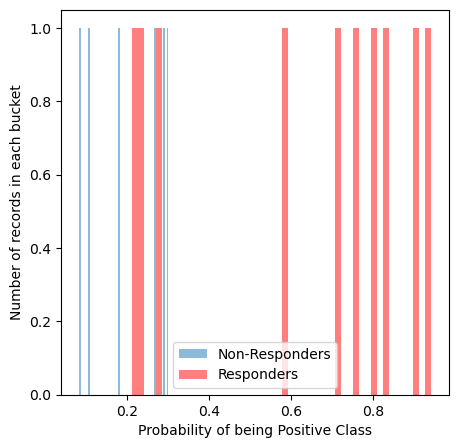

In [22]:
plt.figure(figsize=(5, 5))
plt.hist(prediction[y_test==0], label='Non-Responders', alpha = 0.5, bins = 50)
plt.hist(prediction[y_test==1], label='Responders', alpha=0.5, bins = 50, color = 'r')
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [23]:
df_rf_test = X_test.copy()
df_rf_test.loc[test_index, 'test_proba'] = prediction
df_rf_test.loc[test_index, 'target'] = y
df1 = pd.concat([X_train, df_rf_test], sort=False).sort_index()

In [24]:
df1

,Isopropyl alcohol ; Propyl alcohol,But-2-enoic acid ; Diacetyl ; Gamma-Butyrolactone ; Oxolan-3-one,2-Aminoacrylic acid ; 2-aminoacrylic acid,D-Proline ; D-proline ; L-Proline ; L-proline ; acetamidopropanal,5-Aminopentanoic acid ; Betaine ; HMDB02141 ; L-Valine ; L-valine ; Vaporole ; glycine betaine,"Erythrono-1,4-lactone ; Methylmalonate ; Methylmalonic acid ; Succinate ; Succinic acid ; Threonolactone",Aminomalonic acid,1-Pyrroline-4-hydroxy-2-carboxylate ; 5-oxoprolinate ; HMDB01843 ; L-1-Pyrroline-3-hydroxy-5-carboxylate ; Pyroglutamic acid ; Pyrrolidonecarboxylic acid ; Pyrroline hydroxycarboxylic acid,4-acetamidobutanal ; D-Pipecolic acid ; HMDB04226 ; L-Pipecolic acid ; L-pipecolic acid ; Pipecolic acid,(S)-2-Acetolactate ; 2-Acetolactate ; Dimethylmalonic acid ; Ethylmalonic acid ; Glutaric acid ; Methylsuccinic acid ; Monoethyl malonic acid,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
0,1.478482,-0.288254,-0.876061,-0.878128,0.057627,-0.684360,0.203592,-0.576189,-0.513859,0.455643,...,-0.374868,-1.214645,0.893861,-1.133688,-0.355474,0.348388,-0.715142,0.917747,0.719467,1.0
1,-0.326031,0.451966,-0.480567,-0.172004,0.648200,-0.360677,-1.177505,-1.178544,-1.184908,0.953044,...,-1.143644,0.100907,-0.983495,-0.980514,-1.095321,-2.039662,-1.648273,0.546335,NaN,NaN
2,0.942438,0.780383,-1.207490,-0.472964,0.588242,-0.814626,0.759337,0.573815,0.563809,-0.758589,...,0.087119,-1.055573,-0.144555,-1.008790,-0.203740,-0.495743,-0.593609,-0.405604,NaN,NaN
3,-1.524667,-1.551050,1.020583,0.957741,1.228624,-0.565003,0.300370,1.584796,1.714780,-0.861220,...,-0.092688,-0.234557,0.369370,0.427341,-0.300374,-0.764445,0.635713,-0.990412,NaN,NaN
4,-1.550036,-0.160944,-0.495389,0.375264,-1.531009,-0.809771,-0.844673,-0.296830,-0.626663,-0.987028,...,-1.236372,0.386673,-1.756575,1.433815,-2.084695,-0.606498,-1.141435,-0.256840,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,-1.575049,-0.814235,0.002034,0.072595,0.862519,-0.572718,-0.653726,1.655676,1.362594,-0.406270,...,0.135424,0.145342,0.260952,0.355314,-0.266206,0.034540,1.013079,-0.031460,NaN,NaN
74,0.429424,0.295581,-0.744181,-0.175461,0.721404,-0.762719,0.663899,0.784040,0.803143,-0.779930,...,0.049729,-0.884850,-0.037688,-0.710158,-0.223834,-0.551617,-0.337982,-0.527210,NaN,NaN
75,-0.473860,-0.599552,-0.290169,0.437649,-0.279688,-0.000378,-0.719738,0.437449,0.292331,1.140907,...,-0.238768,-0.200126,-0.132882,-0.384627,0.033676,0.596106,-0.280565,0.922484,0.907333,1.0
76,-0.826081,-1.411605,-0.945078,-0.191828,-0.954968,-0.599425,-1.419025,0.193840,0.178740,-0.614238,...,-0.540407,-0.178169,-0.674045,-0.485018,-0.643004,0.083741,-0.345147,0.099728,NaN,NaN


In [25]:
df1_main = df1.iloc[:51, ]
x = max(prediction[y_test == 0])
df1_main = df1_main.loc[(df1_main['test_proba'] > x)]
df1_main.shape

(3, 199)

In [26]:
df1_main.index.values #0 40 41 42

array([ 0, 42, 43], dtype=int64)

In [27]:
#define the number of iterations for model training and testing
N = 50

#define a list to store the probabilities
prediction2 = []

#define a list to store the number of features selected in each iteration
num_features2 = []

#define a list to store accuracy, precision and recall 
model2 = SVC(C=1, gamma=1, probability=True)
acc_score2, rec_score2, pre_score2 = [], [], []

#run a for loop N times and store the prediction probabilities of each run
for i in range(N):
    #define the base estimator for feature selection
    base_estimator = RandomForestClassifier(n_estimators=150, class_weight='balanced')
    base_estimator.fit(X_train, y_train)
    
    #compute the importances of each feature
    importances = base_estimator.feature_importances_
    
    #use SelectFromModel and mean importances to select important features
    sfm = SelectFromModel(base_estimator, threshold = importances.mean())
    sfm.fit(X_train, y_train)
    
    #transform the train-test data using important features
    X_train_new = pd.DataFrame(data = sfm.transform(X_train), columns = X_train.columns[sfm.get_support(1)])
    X_test_new = pd.DataFrame(data = sfm.transform(X_test), columns = X_train.columns[sfm.get_support(1)])
    
    print(f'Features selected during iteration {i}: {len(X_train_new.columns)}')
    num_features2.append(len(X_train_new.columns))

    #define the SVM model and train it
    model2.fit(X_train_new, y_train)
    
    #comput predictions
    y_pred2 = model2.predict(X_test_new)
    acc_score2.append(accuracy_score(y_test, y_pred2))
    rec_score2.append(recall_score(y_test, y_pred2, pos_label=1))
    pre_score2.append(precision_score(y_test, y_pred2, pos_label=1))
    prediction2.append(model2.predict_proba(X_test_new))


acc_score2 = np.array(acc_score2)
rec_score2 = np.array(rec_score2)
pre_score2 = np.array(pre_score2)
print(f'Accuracy score: {np.mean(acc_score2)}, Standard deviation: {np.std(acc_score2)}')
print(f'Recall score: {np.mean(rec_score2)}, Standard deviation: {np.std(rec_score2)}')
print(f'Precision score: {np.mean(pre_score2)}, Standard deviation: {np.std(pre_score2)}')


prediction2 = np.array(prediction2)
prediction2 = np.mean(prediction2, axis=0)[:, 1]

Features selected during iteration 0: 74
Features selected during iteration 1: 68
Features selected during iteration 2: 66
Features selected during iteration 3: 57
Features selected during iteration 4: 68
Features selected during iteration 5: 60
Features selected during iteration 6: 60
Features selected during iteration 7: 54
Features selected during iteration 8: 65
Features selected during iteration 9: 63
Features selected during iteration 10: 64
Features selected during iteration 11: 65
Features selected during iteration 12: 61
Features selected during iteration 13: 60
Features selected during iteration 14: 56
Features selected during iteration 15: 57
Features selected during iteration 16: 67
Features selected during iteration 17: 61
Features selected during iteration 18: 64
Features selected during iteration 19: 69
Features selected during iteration 20: 65
Features selected during iteration 21: 56
Features selected during iteration 22: 68
Features selected during iteration 23: 77
Fe

In [28]:
print(f'Average number of features being selected: {np.mean(num_features2)}')

Average number of features being selected: 63.0


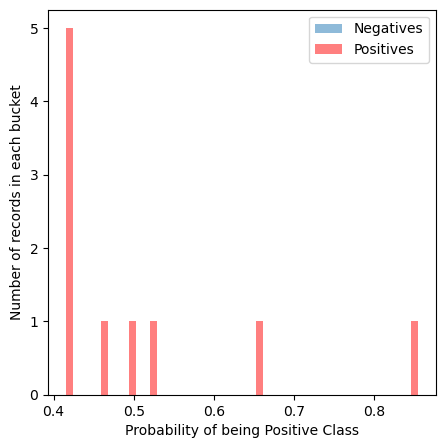

In [29]:
plt.figure(figsize=(5,5))
plt.hist(prediction2[y_test==0], label='Negatives', alpha = 0.5, bins = 50)
plt.hist(prediction2[y_test==1], label='Positives', alpha=0.5, bins = 50, color = 'r')
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [30]:
df_svm_test = X_test.copy()
df_svm_test.loc[test_index, 'test_proba'] = prediction2
df_svm_test.loc[test_index, 'target'] = y_test
df2 = pd.concat([X_train, df_svm_test], sort=False).sort_index()

In [31]:
df2_main = df2.iloc[:51, ]
df2_main = df2_main.loc[(df2_main['test_proba'] > max(prediction2[y_test == 0]))]
df2_main

,Isopropyl alcohol ; Propyl alcohol,But-2-enoic acid ; Diacetyl ; Gamma-Butyrolactone ; Oxolan-3-one,2-Aminoacrylic acid ; 2-aminoacrylic acid,D-Proline ; D-proline ; L-Proline ; L-proline ; acetamidopropanal,5-Aminopentanoic acid ; Betaine ; HMDB02141 ; L-Valine ; L-valine ; Vaporole ; glycine betaine,"Erythrono-1,4-lactone ; Methylmalonate ; Methylmalonic acid ; Succinate ; Succinic acid ; Threonolactone",Aminomalonic acid,1-Pyrroline-4-hydroxy-2-carboxylate ; 5-oxoprolinate ; HMDB01843 ; L-1-Pyrroline-3-hydroxy-5-carboxylate ; Pyroglutamic acid ; Pyrrolidonecarboxylic acid ; Pyrroline hydroxycarboxylic acid,4-acetamidobutanal ; D-Pipecolic acid ; HMDB04226 ; L-Pipecolic acid ; L-pipecolic acid ; Pipecolic acid,(S)-2-Acetolactate ; 2-Acetolactate ; Dimethylmalonic acid ; Ethylmalonic acid ; Glutaric acid ; Methylsuccinic acid ; Monoethyl malonic acid,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
0,1.478482,-0.288254,-0.876061,-0.878128,0.057627,-0.684360,0.203592,-0.576189,-0.513859,0.455643,...,-0.374868,-1.214645,0.893861,-1.133688,-0.355474,0.348388,-0.715142,0.917747,0.854287,1.0
41,0.197645,-0.037413,-0.322753,-0.375304,1.927602,0.108888,0.360594,0.753382,1.115268,-0.198553,...,2.372916,0.707587,1.534275,-0.421098,-0.339184,1.836702,1.262373,-0.397172,0.415158,1.0
42,0.967723,0.765943,0.463555,-0.909956,1.210658,0.419596,2.199793,2.187483,3.059113,-0.998358,...,1.807791,-0.974166,1.864532,0.248684,0.761768,1.051869,1.496163,1.432989,0.499337,1.0
43,-0.189990,0.054920,0.237653,0.944974,0.264553,0.482423,-0.156150,0.633784,0.383879,2.555461,...,0.004338,-0.217821,0.303267,-0.303717,0.579045,1.009045,-0.228516,1.585582,0.652382,1.0


In [32]:
df2_main.index.values #40 41 42

array([ 0, 41, 42, 43], dtype=int64)

In [33]:
#define the number of iterations for model training and testing
N = 50

#define a list to store the probabilities
prediction3 = []

#define a list to store the number of features being selected in each iteration
num_features3 = []

#define the XGBoost model
model3 = XGBClassifier()

#define a list to store accuracy, precision and recall 
acc_score3, rec_score3, pre_score3 = [], [], []

#run a for loop N times and store the prediction probabilities of each run
for i in range(N):
    #define base estimator to compute feature importances
    base_estimator = XGBClassifier()
    base_estimator.fit(X_train, y_train)
    
    #compute feature importances
    importances = base_estimator.feature_importances_
    
    #define SFM model to select important features
    sfm = SelectFromModel(base_estimator, threshold = importances.mean())
    sfm.fit(X_train, y_train)
    
    #transform train and test sets using best features
    X_train_new = pd.DataFrame(data = sfm.transform(X_train), columns = X_train.columns[sfm.get_support(1)])
    X_test_new = pd.DataFrame(data = sfm.transform(X_test), columns = X_test.columns[sfm.get_support(1)])
    
    print(f'Features selected during iteration {i}: {len(X_train_new.columns)}')
    num_features3.append(len(X_train_new.columns))

    #define XGBoost model and train it
    model3.fit(X_train_new, y_train)
    
    #compute predictions
    y_pred3 = model3.predict(X_test_new)
    acc_score3.append(accuracy_score(y_test, y_pred3))
    rec_score3.append(recall_score(y_test, y_pred3, pos_label=1))
    pre_score3.append(precision_score(y_test, y_pred3, pos_label=1))
    prediction3.append(model3.predict_proba(X_test_new))


acc_score3 = np.array(acc_score3)
rec_score3 = np.array(rec_score3)
pre_score3 = np.array(pre_score3)
print(f'Accuracy score: {np.mean(acc_score3)}, Standard deviation: {np.std(acc_score3)}')
print(f'Recall score: {np.mean(rec_score3)}, Standard deviation: {np.std(rec_score3)}')
print(f'Precision score: {np.mean(pre_score3)}, Standard deviation: {np.std(pre_score3)}')


prediction3 = np.array(prediction3)
prediction3 = np.mean(prediction3, axis=0)[:, 1]

Features selected during iteration 0: 32
Features selected during iteration 1: 32
Features selected during iteration 2: 32
Features selected during iteration 3: 32
Features selected during iteration 4: 32
Features selected during iteration 5: 32
Features selected during iteration 6: 32
Features selected during iteration 7: 32
Features selected during iteration 8: 32
Features selected during iteration 9: 32
Features selected during iteration 10: 32
Features selected during iteration 11: 32
Features selected during iteration 12: 32
Features selected during iteration 13: 32
Features selected during iteration 14: 32
Features selected during iteration 15: 32
Features selected during iteration 16: 32
Features selected during iteration 17: 32
Features selected during iteration 18: 32
Features selected during iteration 19: 32
Features selected during iteration 20: 32
Features selected during iteration 21: 32
Features selected during iteration 22: 32
Features selected during iteration 23: 32
Fe

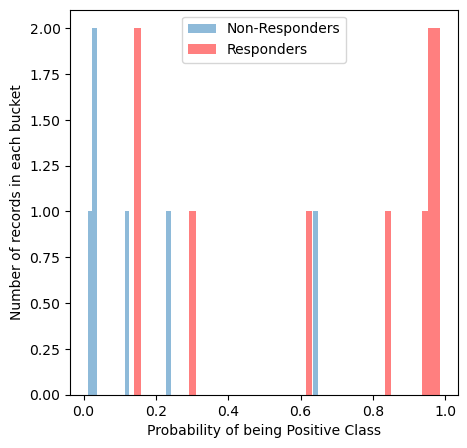

In [34]:
plt.figure(figsize=(5, 5))
plt.hist(prediction3[y_test==0], label='Non-Responders', bins = 50, alpha = 0.5)
plt.hist(prediction3[y_test==1], label='Responders', alpha=0.5, color='r', bins = 50)
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [35]:
df_xg = X_test.copy()
df_xg.loc[test_index, 'test_proba'] = prediction3
df_xg.loc[test_index, 'target'] = y_test
df3 = pd.concat([X_train, df_xg], sort=False).sort_index()
df3

,Isopropyl alcohol ; Propyl alcohol,But-2-enoic acid ; Diacetyl ; Gamma-Butyrolactone ; Oxolan-3-one,2-Aminoacrylic acid ; 2-aminoacrylic acid,D-Proline ; D-proline ; L-Proline ; L-proline ; acetamidopropanal,5-Aminopentanoic acid ; Betaine ; HMDB02141 ; L-Valine ; L-valine ; Vaporole ; glycine betaine,"Erythrono-1,4-lactone ; Methylmalonate ; Methylmalonic acid ; Succinate ; Succinic acid ; Threonolactone",Aminomalonic acid,1-Pyrroline-4-hydroxy-2-carboxylate ; 5-oxoprolinate ; HMDB01843 ; L-1-Pyrroline-3-hydroxy-5-carboxylate ; Pyroglutamic acid ; Pyrrolidonecarboxylic acid ; Pyrroline hydroxycarboxylic acid,4-acetamidobutanal ; D-Pipecolic acid ; HMDB04226 ; L-Pipecolic acid ; L-pipecolic acid ; Pipecolic acid,(S)-2-Acetolactate ; 2-Acetolactate ; Dimethylmalonic acid ; Ethylmalonic acid ; Glutaric acid ; Methylsuccinic acid ; Monoethyl malonic acid,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
0,1.478482,-0.288254,-0.876061,-0.878128,0.057627,-0.684360,0.203592,-0.576189,-0.513859,0.455643,...,-0.374868,-1.214645,0.893861,-1.133688,-0.355474,0.348388,-0.715142,0.917747,0.834571,1.0
1,-0.326031,0.451966,-0.480567,-0.172004,0.648200,-0.360677,-1.177505,-1.178544,-1.184908,0.953044,...,-1.143644,0.100907,-0.983495,-0.980514,-1.095321,-2.039662,-1.648273,0.546335,NaN,NaN
2,0.942438,0.780383,-1.207490,-0.472964,0.588242,-0.814626,0.759337,0.573815,0.563809,-0.758589,...,0.087119,-1.055573,-0.144555,-1.008790,-0.203740,-0.495743,-0.593609,-0.405604,NaN,NaN
3,-1.524667,-1.551050,1.020583,0.957741,1.228624,-0.565003,0.300370,1.584796,1.714780,-0.861220,...,-0.092688,-0.234557,0.369370,0.427341,-0.300374,-0.764445,0.635713,-0.990412,NaN,NaN
4,-1.550036,-0.160944,-0.495389,0.375264,-1.531009,-0.809771,-0.844673,-0.296830,-0.626663,-0.987028,...,-1.236372,0.386673,-1.756575,1.433815,-2.084695,-0.606498,-1.141435,-0.256840,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,-1.575049,-0.814235,0.002034,0.072595,0.862519,-0.572718,-0.653726,1.655676,1.362594,-0.406270,...,0.135424,0.145342,0.260952,0.355314,-0.266206,0.034540,1.013079,-0.031460,NaN,NaN
74,0.429424,0.295581,-0.744181,-0.175461,0.721404,-0.762719,0.663899,0.784040,0.803143,-0.779930,...,0.049729,-0.884850,-0.037688,-0.710158,-0.223834,-0.551617,-0.337982,-0.527210,NaN,NaN
75,-0.473860,-0.599552,-0.290169,0.437649,-0.279688,-0.000378,-0.719738,0.437449,0.292331,1.140907,...,-0.238768,-0.200126,-0.132882,-0.384627,0.033676,0.596106,-0.280565,0.922484,0.968811,1.0
76,-0.826081,-1.411605,-0.945078,-0.191828,-0.954968,-0.599425,-1.419025,0.193840,0.178740,-0.614238,...,-0.540407,-0.178169,-0.674045,-0.485018,-0.643004,0.083741,-0.345147,0.099728,NaN,NaN


In [36]:
df3_main = df3.iloc[:51, ]
df3_main = df3_main.loc[(df3_main['test_proba'] > max(prediction3[y_test == 0]))]
df3_main

,Isopropyl alcohol ; Propyl alcohol,But-2-enoic acid ; Diacetyl ; Gamma-Butyrolactone ; Oxolan-3-one,2-Aminoacrylic acid ; 2-aminoacrylic acid,D-Proline ; D-proline ; L-Proline ; L-proline ; acetamidopropanal,5-Aminopentanoic acid ; Betaine ; HMDB02141 ; L-Valine ; L-valine ; Vaporole ; glycine betaine,"Erythrono-1,4-lactone ; Methylmalonate ; Methylmalonic acid ; Succinate ; Succinic acid ; Threonolactone",Aminomalonic acid,1-Pyrroline-4-hydroxy-2-carboxylate ; 5-oxoprolinate ; HMDB01843 ; L-1-Pyrroline-3-hydroxy-5-carboxylate ; Pyroglutamic acid ; Pyrrolidonecarboxylic acid ; Pyrroline hydroxycarboxylic acid,4-acetamidobutanal ; D-Pipecolic acid ; HMDB04226 ; L-Pipecolic acid ; L-pipecolic acid ; Pipecolic acid,(S)-2-Acetolactate ; 2-Acetolactate ; Dimethylmalonic acid ; Ethylmalonic acid ; Glutaric acid ; Methylsuccinic acid ; Monoethyl malonic acid,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
0,1.478482,-0.288254,-0.876061,-0.878128,0.057627,-0.684360,0.203592,-0.576189,-0.513859,0.455643,...,-0.374868,-1.214645,0.893861,-1.133688,-0.355474,0.348388,-0.715142,0.917747,0.834571,1.0
43,-0.189990,0.054920,0.237653,0.944974,0.264553,0.482423,-0.156150,0.633784,0.383879,2.555461,...,0.004338,-0.217821,0.303267,-0.303717,0.579045,1.009045,-0.228516,1.585582,0.961472,1.0


In [37]:
common_list = []
common_list.extend(list(df1_main.index.values))
common_list.extend(list(df2_main.index.values))
common_list.extend(list(df3_main.index.values))

In [38]:
cl = set(common_list)
cl

{0, 41, 42, 43}

In [39]:
df1_total = df1.loc[:51, ]
df1_total = df1_total.loc[(df1_total['target'] == 1.0)]
df1_total

,Isopropyl alcohol ; Propyl alcohol,But-2-enoic acid ; Diacetyl ; Gamma-Butyrolactone ; Oxolan-3-one,2-Aminoacrylic acid ; 2-aminoacrylic acid,D-Proline ; D-proline ; L-Proline ; L-proline ; acetamidopropanal,5-Aminopentanoic acid ; Betaine ; HMDB02141 ; L-Valine ; L-valine ; Vaporole ; glycine betaine,"Erythrono-1,4-lactone ; Methylmalonate ; Methylmalonic acid ; Succinate ; Succinic acid ; Threonolactone",Aminomalonic acid,1-Pyrroline-4-hydroxy-2-carboxylate ; 5-oxoprolinate ; HMDB01843 ; L-1-Pyrroline-3-hydroxy-5-carboxylate ; Pyroglutamic acid ; Pyrrolidonecarboxylic acid ; Pyrroline hydroxycarboxylic acid,4-acetamidobutanal ; D-Pipecolic acid ; HMDB04226 ; L-Pipecolic acid ; L-pipecolic acid ; Pipecolic acid,(S)-2-Acetolactate ; 2-Acetolactate ; Dimethylmalonic acid ; Ethylmalonic acid ; Glutaric acid ; Methylsuccinic acid ; Monoethyl malonic acid,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
0,1.478482,-0.288254,-0.876061,-0.878128,0.057627,-0.684360,0.203592,-0.576189,-0.513859,0.455643,...,-0.374868,-1.214645,0.893861,-1.133688,-0.355474,0.348388,-0.715142,0.917747,0.719467,1.0
41,0.197645,-0.037413,-0.322753,-0.375304,1.927602,0.108888,0.360594,0.753382,1.115268,-0.198553,...,2.372916,0.707587,1.534275,-0.421098,-0.339184,1.836702,1.262373,-0.397172,0.212400,1.0
42,0.967723,0.765943,0.463555,-0.909956,1.210658,0.419596,2.199793,2.187483,3.059113,-0.998358,...,1.807791,-0.974166,1.864532,0.248684,0.761768,1.051869,1.496163,1.432989,0.581867,1.0
43,-0.189990,0.054920,0.237653,0.944974,0.264553,0.482423,-0.156150,0.633784,0.383879,2.555461,...,0.004338,-0.217821,0.303267,-0.303717,0.579045,1.009045,-0.228516,1.585582,0.801867,1.0


In [40]:
with open('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\ModelRunNTimes\\outputs\\master_list_metabolomics.txt', 'w') as f:
    for i in cl:
        f.write(f'{i}\n')

In [41]:
l = []
l.extend(df1_total.index.values)
with open('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\ModelRunNTimes\\outputs\\total_metabolomics.txt', 'w') as f:
    for i in l:
        f.write(f'{i}\n')